In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import bin_tools
from wotan import flatten
import time
from OrionPY import OrionTools, Tools
from multiprocessing import Pool

In [2]:
### REBINNED - Load data as numpy array and remove empty arrays
data = np.load('/data/jpr64/rebinned_data_test.npy', allow_pickle = True)
print(np.size(data))
# data = np.delete(data, np.where([y.size==0 for y in data]))
# data = np.delete(data, np.where([y.any() < 0. for y in data]))


8957


In [12]:
lc = []

for i in data:
    idx = (~np.isnan(i[:,1])) & (i[:,1] > 0.)
    i = i[idx]
    lc.append(i)

lc = [x for x in lc if not x.shape == (0,3)]
print(np.size(lc))
index_keep = [i for i, j in enumerate(lc) if not j.shape == (0,3) ]

8913


/home/jpr64/.conda/envs/orion_jake/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [13]:
# %%time
mean_mag = np.zeros(np.size(lc))
rms_mag = np.zeros(np.size(lc))

for i, j in enumerate(lc):
        magnitudes = -2.5 * np.log10(j[:,1]) + 20.2
        mean_mag[i] = np.nanmean(magnitudes)
#         print(mean_mag[i])
        rms_mag[i] = np.sqrt(np.mean(np.square(mean_mag[i] - magnitudes)))
#         print(rms_mag[i])

<IPython.core.display.Javascript object>


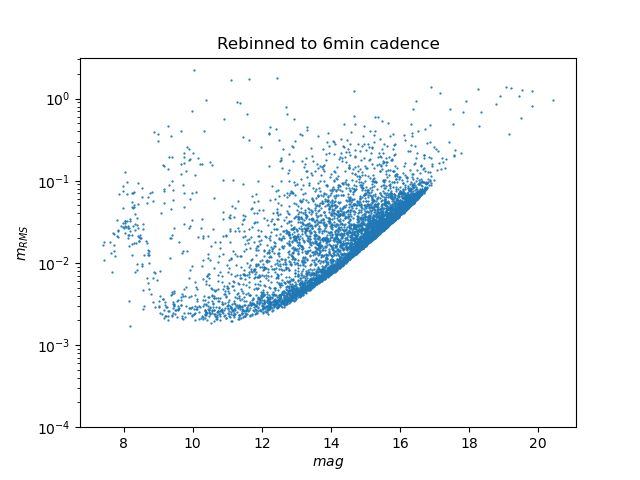

(0.0001, 3.1498896552287357)

In [14]:
%matplotlib notebook
plt.plot(mean_mag, rms_mag, linestyle = '', marker = 'o', markersize = 0.6)
plt.ylabel(r'$m_{RMS}$')
plt.xlabel(r'$mag$')
plt.yscale('log')
plt.title(r'Rebinned to 6min cadence')
plt.ylim(0.0001)

In [51]:
### LOWESS
from multiprocessing import Pool, cpu_count

def detrend(lightcurve):
    flatten_lc, trend_lc = flatten(
        lightcurve[:,0],                 # Array of time values
        lightcurve[:,1],                 # Array of flux values
        method='lowess',
        window_length = 30 ,    # The length of the filter window in units of ``time`` - 3 hours = 0.125
        break_tolerance = 1,    # Split into segments at breaks longer than that
        return_trend=True,    # Return trend and flattened light curve
        )
    return np.array((flatten_lc, trend_lc))

def magnitudes(lightcurve):
    lightcurve = lightcurve.transpose()
    mags = mag(lightcurve[:,1])
    mean_mag = np.nanmean(mags)
    rms_mag = np.sqrt(np.nanmean(np.square(mags - mean_mag)))
    return np.array((mean_mag, rms_mag))

# # def magnitudes_original_data(lc):
#     lc = lc.transpose()
#     mags = mag(lc)
#     mean_mag = np.nanmean(mags)
#     rms_mag = np.sqrt(np.nanmean(np.square(mags - mean_mag)))
#     return mean_mag, rms_mag

def mag(flux):
    return -2.5*np.log10(flux) + 20.2

In [38]:
v

CPU times: user 2.26 s, sys: 8.29 s, total: 10.6 s
Wall time: 56.5 s


In [53]:
lightcurve = lc[365]

flatten(
    lightcurve[:,0],                 # Array of time values
    lightcurve[:,1],                 # Array of flux values
    method='lowess',
    window_length=30,    # The length of the filter window in units of ``time`` - 3 hours = 0.125
    break_tolerance=0.4,    # Split into segments at breaks longer than that
    return_trend=True,    # Return trend and flattened light curve
    )

# plt.plot(lightcurve[:,0], lightcurve[:,1])
# plt.show()

(array([1.00496372, 1.00083598, 0.99894309, ..., 1.00126939, 1.00053874,
        0.99812326]),
 array([3144.30138852, 3152.52446539, 3157.36929448, ..., 3144.18190052,
        3144.10229201, 3144.06880262]))

In [32]:
### Calculates magnitudes and rms of detrended lc

with Pool(30) as p:
    detrend_mag = p.map(magnitudes, lc_detrend_2)
    p.close()

detrend_mag = np.array(detrend_mag)

/home/jpr64/.conda/envs/orion_jake/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in log10
/home/jpr64/.conda/envs/orion_jake/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice
/home/jpr64/.conda/envs/orion_jake/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
/home/jpr64/.conda/envs/orion_jake/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in log10
/home/jpr64/.conda/envs/orion_jake/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in log10
/home/jpr64/.conda/envs/orion_jake/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in log10
/home/jpr64/.conda/envs/orion_jake/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in log10
/home/jpr64/.conda/envs/orion_jake/lib/python3.7/s

In [33]:
detrend_mag[365]

array([1.14523889e+01, 2.13556646e-03])

<IPython.core.display.Javascript object>


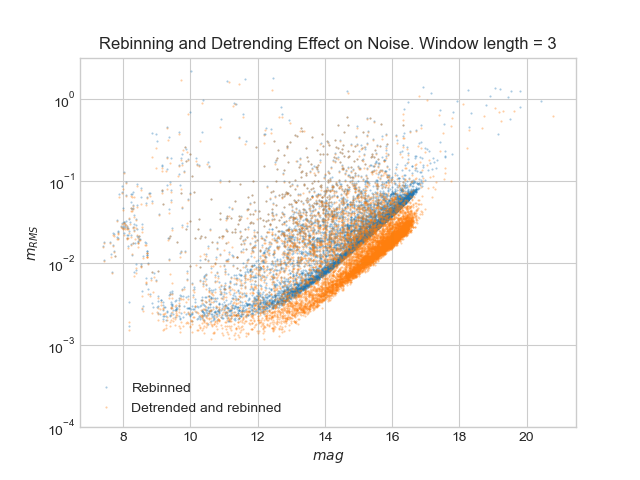

In [54]:
%matplotlib notebook
# unbin_mag = np.array(unbin_mag)

plt.style.use('seaborn-whitegrid')
plt.plot(mean_mag, rms_mag, linestyle = '', marker = 'o', markersize = 0.5,alpha = 0.4, label='Rebinned')
plt.plot(detrend_mag[:,0], detrend_mag[:,1], linestyle = '', marker = 'o', markersize = 0.5,alpha = 0.4, label='Detrended and rebinned')
plt.ylabel(r'$m_{RMS}$')
plt.xlabel(r'$mag$')
plt.yscale('log')
plt.legend()
plt.title(r'Rebinning and Detrending Effect on Noise. Window length = 3')
plt.ylim(0.0001)
plt.show()

In [ ]:
# %matplotlib notebook
# plt.figure()
# plt.plot(mean_mag, delta_rms(rms_mag), linestyle = '', marker = ',', markersize = 0.5,alpha = 0.5, label='Rebinned', color = 'r')
# plt.plot(detrend_mag[:,0], delta_rms(detrend_mag[:,1]), linestyle = '', marker = ',', markersize = 0.5,alpha = 0.5, color = 'orange', label='Detrended and rebinned')
# plt.ylabel(r'$m_{RMS}$')
# plt.xlabel(r'$mag$')
# plt.yscale('log')
# plt.legend()
# plt.title(r'Rebinning and Detrending Effect on Noise')
# # plt.ylim(0.0001)
# plt.show()

In [ ]:
# def delta_rms(rms):

#     return (1 - (rms / unbin_mag[index_keep,1]))

In [ ]:
%matplotlib notebook
plt.plot(detrend_mag[:,0], detrend_mag[:,1], linestyle = '', marker = 'o', markersize = 0.6)
plt.ylabel(r'$m_{RMS}$')
plt.xlabel(r'$mag$')
plt.yscale('log')
plt.title(r'Rebinned to 6min cadence')
plt.ylim(0.0001)

In [ ]:
# (time, flux) = (data_no_bin.time[index_keep], data_no_bin.flux[index_keep])

In [ ]:
# if __name__ == '__main__':
#     with Pool(50) as p:
#         unbin_mag = p.map(mag_no_bin, flux)
#         p.close()

In [ ]:
# def mag_no_bin(flux):
#     mags = mag(flux)
#     mean_mag = np.nanmean(mags)
#     rms_mag = np.sqrt(np.nanmean(np.square(mags - mean_mag)))
#     return np.array((mean_mag, rms_mag))

In [ ]:
### Loading original data and calculating original mean and rms

# data_no_bin = Tools()
